In [47]:
%load_ext autoreload
%autoreload 2

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

import sys
sys.path.insert(0, "..") 

from src.data import make_dataset
from src.visualization import visualize
from sklearn.linear_model import LinearRegression, SGDClassifier, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. non-linear data
Let's generate some synthetic data get get a grip on linear models and regularization.

In [36]:
# we make n observations, with some features
np.random.seed(42)
n = 100 # we start with just 100 observations
k = 1 # and one feature
X, y, W = make_dataset.generate_linear_data(n, k)
W

array([[11]])

After having created some simple dataset with a linear relation in it, let's fit a model.

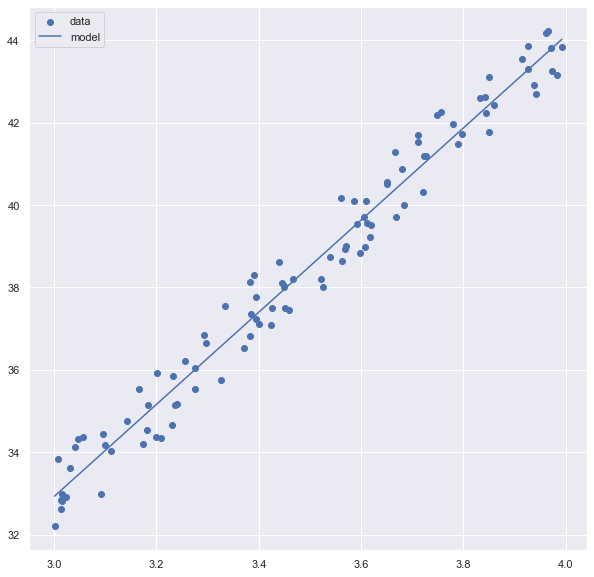

In [37]:
linreg = LinearRegression()
visualize.predictions(X, y, linreg)

In [38]:
linreg.coef_, W

(array([[11.18443895]]), array([[11]]))

We can see that we found a nice model. The actual weight was 11, and we found around 11.2, which is nice considering the noise and just 100 observations. Because the data has just one feature, we can easily visualize the trainset and the prediction.

Let's see how this scales.

In [39]:
np.random.seed(42)
n = 100 
k = 15 # increase this to 15 features
X, y, W = make_dataset.generate_linear_data(n, k, noise_range=5) # and increase the noise

linreg = LinearRegression()
linreg.fit(X, y);

The nice thing of a synthetic dataset is that we know what the weights are. We can see how close we get. The differences are due to the noise. While we can see some errors growing, this is still pretty good, considering the increased noise and the small amount of data.

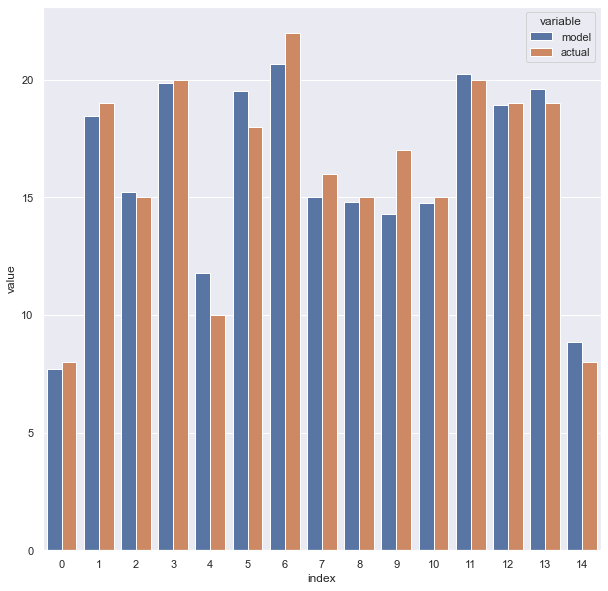

In [40]:
weights = pd.DataFrame(zip(linreg.coef_.T.flatten(), W.flatten()), columns=['model', 'actual'])
data = weights.reset_index().melt(id_vars='index')
sns.barplot(data = data, x = 'index', y = 'value', hue = 'variable');

We can't visualize 10 features easily. But we can simply plot the outcomes. If we plot the prediction on one axis, and the actual value on the other axis, we expect a diagonal line. 

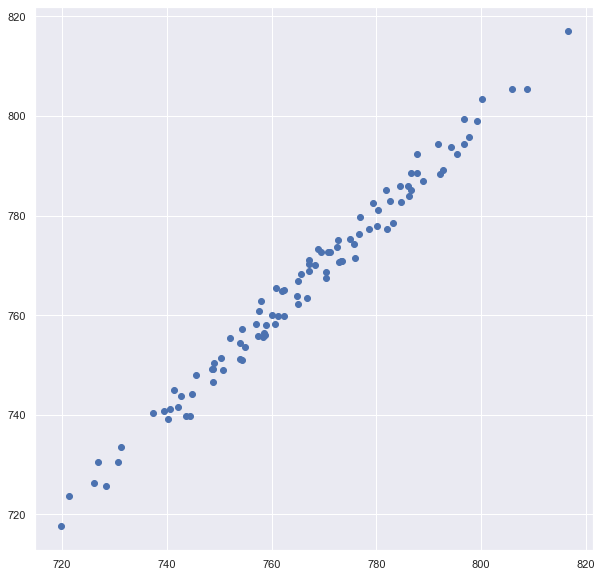

In [41]:
yhat = linreg.predict(X)
plt.scatter(y, yhat);

This is very close to a diagonal line. Even though we missed some weights, we still did a good job. But what if we make the relationship non-linear?

In [42]:
# we create 100 observations
n = 100

# this way, our X will go over the range [-3, 3]
X = 6 * np.random.rand(n, 1) - 3
# let's use a quadratic equation
y = 0.5 * X**2 + X + 2 + np.random.rand(n, 1) 

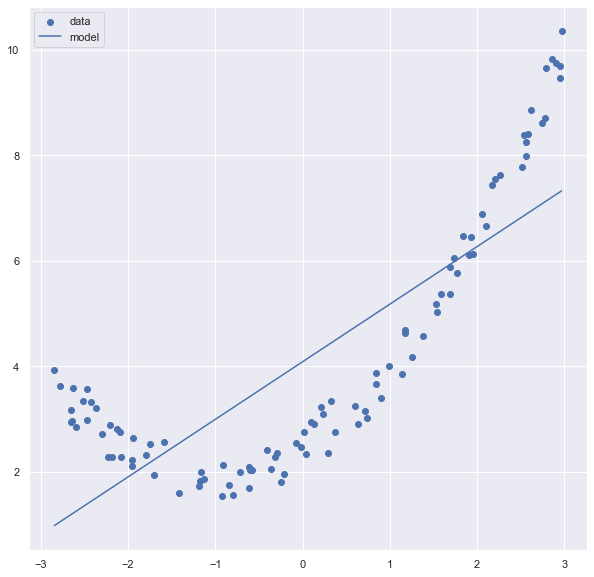

In [43]:
visualize.predictions(X, y, linreg)

Ai.... We can see that, even though the model isn't that complex, we will `never` fit this with a straight line... 
So we will use a trick. We will distort the features by adding polynomial variations.

## 2. Basis expansion

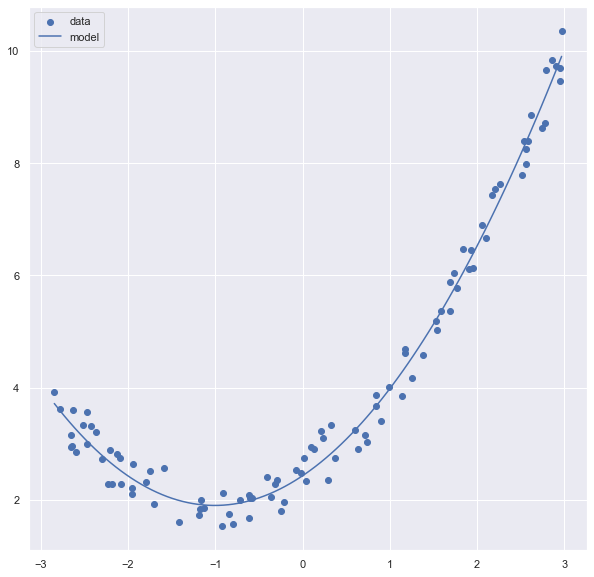

In [44]:
poly = PolynomialFeatures(degree = 3, include_bias=True)

pipe = Pipeline([
            ("poly_features", poly),
            ("lin_reg", linreg),
        ])

visualize.predictions(X, y, pipe)


Ah! much better. But, there is a problem. By just increasing the degree of polynomial features, we will be able to get arbitrarily close to the outcome!

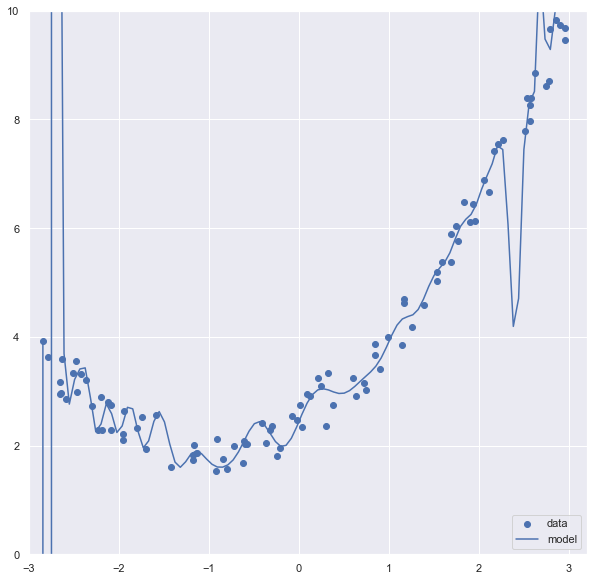

In [45]:
# set the degree to 100 (change it, to see what happens)
degree = 100

polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
std_scaler = StandardScaler()
lin_reg = LinearRegression()

pipe = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])

visualize.predictions(X, y, pipe)
plt.axis([-3, 3.2, 0, 10]);

This is clearly overfitting... The model is much too complex. While this might perform nicely on the trainset, we will do very bad on any testset.

## 3. Regularization
Is there a way to regularize this? In principle, yes. We can use a `Ridge` regularization, for example.

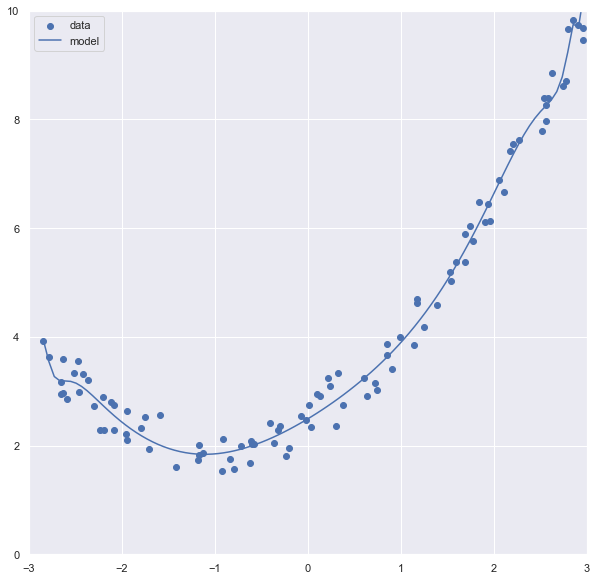

In [46]:
pipe = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("ridge", Ridge(alpha=0.01)),
        ])

visualize.predictions(X, y, pipe)
plt.axis([-3, 3, 0, 10]);

Now, this is much better. A few things to note:

- we are doing two things that oppose each other: one the one hand, we make our model way too complex by using a 100-degree polynomial.
- to counteract that complexity, we regularize the model heavily.

At first glace, you might say, don't make your data so complex to add 100 degree polynomials. One response to that could be: well, but this is to make a point, to teach you how regularization works.

But there is something more to it: sometimes, you have really a lot of features. And you really don't know which features are useful and which features are not. In that case, This could be a way to do *feature selection*. You see that it can work pretty good.

Another point is: we are using linear models. Often, data is not linearly separable. Manipulating the data using transformations may make them linearly separable. Because the polynomial features add really a lot of features, and we might need just a few of them, controlling the weights is usually a good idea. As a rule of thumb, however, the simpler your model is, the better. If two models are more or less equal in performance, you should always pick the simpler model. The more complex the model is, the higher the chances are that you will overfit.

So, let's find out. What is a sensible amount of modification of our data? And after we did that, what is a good amount of regularisation? Well, that sounds like a gridsearch question. So let's implement what we learned in the first lesson: we combine a pipe and gridsearch to find out.

In [48]:
poly_ridge = Pipeline([
            ("poly", PolynomialFeatures()),
            ("scaler", StandardScaler()),
            ("ridge", Ridge()),
        ])


param_grid = {'poly__degree' : [i for i in range(2,20,2)],
    'ridge__alpha': [10**x for x in range(-4,3)]}
gridsearch = GridSearchCV(poly_ridge, param_grid=param_grid, cv=3)
gridsearch.fit(X, y)

gridsearch.best_params_

{'poly__degree': 2, 'ridge__alpha': 0.01}

 But what does this regularisation actually do? Let's find out with the use of the cancer dataset.

In [49]:
X_train, y_train, X_test, y_test = make_dataset.get_cancer_data(split = 0.2)

To make the comparing easier, we create a function that takes a pipe and a list with several values for the amount of regularization (`alpha`) as input, fits the pipe for every value of `alpha`, and plots the weights to compare the impact of different `alpha`'s. You can see how this function operates in `visualize.impact_of_alpha()`.

Let's do this for l2 (ridge)...

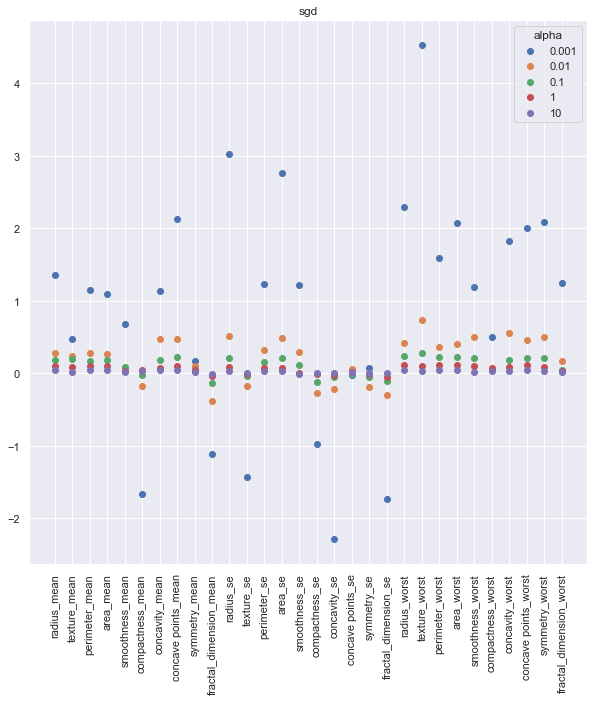

In [50]:
# We make a pipe with a scaler and l2 regularization
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(penalty='l2'))
])

alphaList = [10**i for i in range(-3, 2)]
visualize.impact_of_alpha(alphaList, pipe, X_train, y_train)


...and for l1 (lasso)

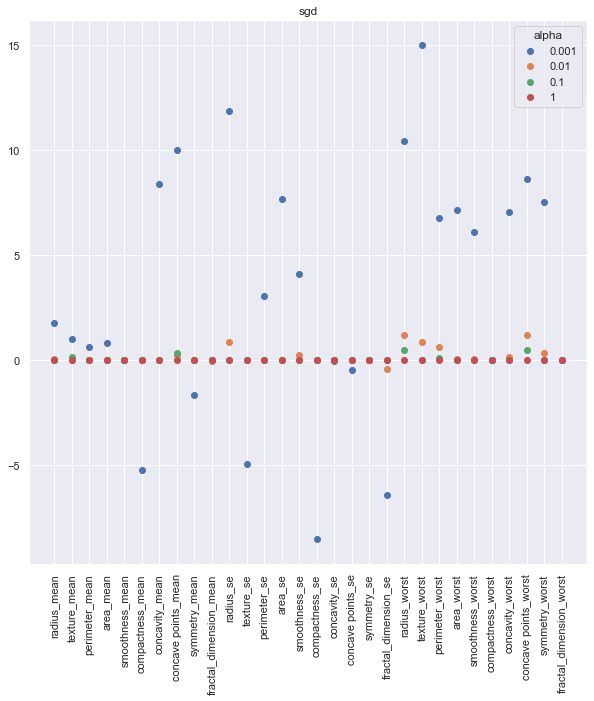

In [51]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
     ('sgd', SGDClassifier(penalty='l1'))
])
alphaList = [10**i for i in range(-3, 1)]
visualize.impact_of_alpha(alphaList, pipe, X_train, y_train)

What is the difference between the two methods? What can you see happening?

Note that alpha corresponds to $\frac{1}{2C}$ in other linear models such as LogisticRegression that use a $C$ value.

A nice way to find the best model, is to use elasticnet. This combines Ridge and Lasso, and has a `l1_ratio` parameter that sets the amount of mixture between the two regularizations. Luckily, we can find out the best ratio and alpha with `ElasticNetCV` for linear regression, and `penalty='elasticnet` in the SGDClassifier

Note that a good choice of list of values for `l1_ratio` is often to put more values close to 1 (i.e. Lasso) and less close to 0 (i.e. Ridge), as in $[.1, .5, .7, .9, .95, .99, 1]$

In [52]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
     ('sgd', SGDClassifier(penalty='elasticnet'))
])

l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
alphaList = [10**i for i in range(-3, 2)]

param_grid = {'sgd__l1_ratio' : l1_ratio,
                'sgd__alpha' : alphaList} 

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3)
gridsearch.fit(X_train, y_train)

gridsearch.best_params_

{'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.99}

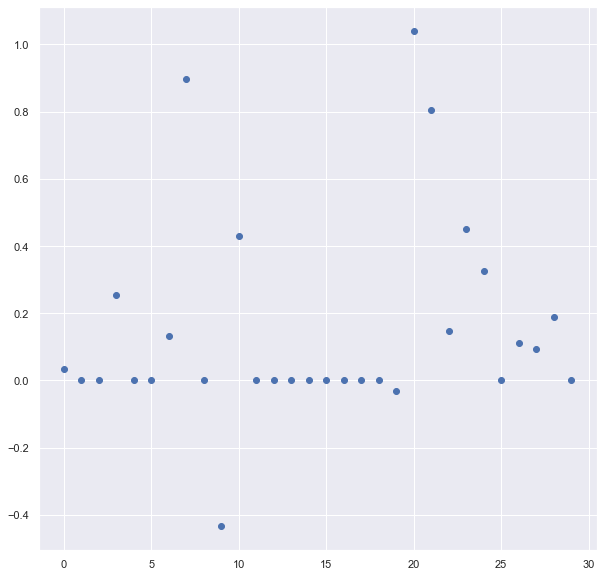

In [53]:
pipe.set_params(**gridsearch.best_params_)
pipe.fit(X_train, y_train)
coefs = pipe.named_steps['sgd'].coef_.flatten()
plt.plot(coefs, 'o');

In [54]:
coefs

array([ 0.03354473,  0.        ,  0.        ,  0.25333058,  0.        ,
        0.        ,  0.13351266,  0.89701408,  0.        , -0.43213977,
        0.43038165,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.03027854,
        1.03885319,  0.80428501,  0.14769918,  0.45139971,  0.32470208,
        0.        ,  0.11232477,  0.09374197,  0.18896503,  0.        ])

In [55]:
# we want the absolute values (the features with the most impact)
absolute_values = np.abs(coefs)
# then find the index of the sorted values
sorted_idx = np.argsort(absolute_values)

# if we want the k highest weights
k = 10
# we select the last k sorted indeces
highest = sorted_idx[-k:]

In [56]:
# these are the k best features, that could be selected to train another (more complex) model
X_train.columns[highest]

Index(['perimeter_worst', 'symmetry_worst', 'area_mean', 'smoothness_worst',
       'radius_se', 'fractal_dimension_mean', 'area_worst', 'texture_worst',
       'concave points_mean', 'radius_worst'],
      dtype='object')